# VGG Model

Create a new VGG model and setup the boilerplate.

In [3]:
%matplotlib inline
path = "data/dogscats/"

from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

import utils; reload(utils)
from utils import plots

import vgg16; reload(vgg16)
from vgg16 import Vgg16

Create a new VGG object and prepare the batches.

> N.B. - the batching (aka mini-batching) is required so that instead of processing in one item at a time, we send in a batch.  This is required to make the best use of the computing capabilities of the hardware and prevent starvation.
We have chosen 64 here since that is the msot we can fit into memory of the GPU

In [4]:
batch_size = 64

vgg = Vgg16()
training_batches = vgg.get_batches(path + "train", batch_size=batch_size)
validation_batches = vgg.get_batches(path + "valid", batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Each batch here can be iterated as a normal python iterable, so when we do next(training_batches), we get the next 64 items.

Now that we have got the batches, we need to "finetune" the network.  This finetuning is required as the original VGG network has many output classes (1000), but we need to use two so we do this:
 * Remove the final layer from VGG (i.e. the densely-connected 1000 nodes)
 * Lock the weights (mark as trainable=false) of the remaining layers
 * Add a new final layer with nodes for number of classes we need to output (2 in this lessons)
 
By locking the weights of the existing layers when we come to train the network using *fit()*, we're **only** trainng the final new layer we added (leaving the existing layers untouched).

In [5]:
vgg.finetune(training_batches)

In [6]:
vgg.fit(training_batches, validation_batches, nb_epoch=1)

Epoch 1/1
23000/23000 [==============================] - 600s - loss: 0.1272 - acc: 0.9677 - val_loss: 0.0731 - val_acc: 0.9825


In theory this will work for any image recognition task (that VGG knows about anyway), since we can just chop off the final layer and replace it with one that meets our needs (i.e. has an appropriate number of nodes for our output classes) and then re-train that final layer.

# Scratch Model in Keras

We can now create the same model from scratch directly in Keras which will give us more control.

Import the boilerplate:

In [76]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image

We import the mappings from VCC IDs -> Imagenet IDs and descriptions.  We'll use these later to display the information.

We'll use Kera's *get_file()* that downloads files and caches them for use later.

In [43]:
FILES_PATH = "http://files.fast.ai/models/"
CLASS_FILE = "imagenet_class_index.json"

fpath = get_file(CLASS_FILE, FILES_PATH + CLASS_FILE, cache_subdir="models")

with open(fpath) as f:
    class_dict = json.load(f)

class_names = [class_dict[str(i)][1] for i in range(len(class_dict))]

At this point we have loaded in the imagenet classes, e.g.

In [44]:
class_dict["0"]

[u'n01440764', u'tench']

In [45]:
class_names[:3]

[u'tench', u'goldfish', u'great_white_shark']

### Building the model

We can now start to build the model up.  VGG uses a few basic building blocks:
 * Convolutional layers
 * Densely Connected layers
 
We'll create a couple of functions to build the layers up.

In [27]:
def ConvolutionBlock(layers, model, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation="relu"))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

def FullyConnectedBlock(model):
    model.add(Dense(4096, activation="relu"))
    model.add(Dropout(0.5))

When VGG was created in 2014, the creators subtracted the average of each of the three (R,G,B) channels first, so that the data for each channel had an average of zero.  Their software also expected that the channels were in BGR order, but python uses RGB so we need to do a little bit of preprocessing so that we're compatible with their model.

In [28]:
# These magic numbers were provided by the VGG team.
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean  # Subtract the mean...
    return x[:,::-1]  # ... then convert bgr->rgb

We can now define the model itself:

In [29]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))
    
    ConvolutionBlock(2, model, 64)
    ConvolutionBlock(2, model, 128)
    ConvolutionBlock(3, model, 256)
    ConvolutionBlock(3, model, 512)
    ConvolutionBlock(3, model, 512)
    
    model.add(Flatten())
    
    FullyConnectedBlock(model)
    FullyConnectedBlock(model)
    
    model.add(Dense(1000, activation="softmax"))
    return model

We can now load the saved weights of the VGG model into our new model here.  This saves us a lot of time since we do not need to spend a lot of time re-training our model from scrath!

In [30]:
fpath = get_file("vgg16.h5", FILES_PATH + "vgg16.h5", cache_subdir="models")

model = VGG_16()
model.load_weights(fpath)

/home/mattdibb/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_4 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


So at this point we have defined the model's structure and loaded the pre-trained weights into the model.  We're ready to use it to *predict()* to get some answers without any further training.

Keras provides some functionality to get batches of data from directories - we'll use the courses's provided wrapper function to load that data in easily.

In [60]:
batch_size = 6

def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

We can now load in some images and make some predictions.

Lets get a few images and see what they are before we do any predictions - this is just for show so that we can visually see what we're feeding to the model (we're getting the images from the validation set, but could be from anywhere).

Found 2000 images belonging to 2 classes.


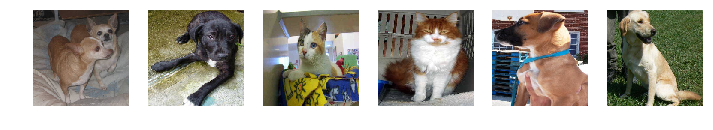

In [66]:
validation_batches = get_batches("valid", batch_size=batch_size)

# Get the images and labels from the batch
images, labels = next(validation_batches)

# Plot to see what the images are for our puny human benefit.
plots(images)

Ok so we have some images to work with - looking at them we as humans know that it is dog, dog, cat, cat, dog, dog.

Lets feed those same images into our model and see what its predictions are:

In [67]:
predictions = model.predict(images)
print(predictions)

[[  1.5609e-06   3.1307e-06   1.3935e-06 ...,   4.5076e-06   6.2268e-05   3.9772e-04]
 [  2.1523e-07   1.7693e-08   3.9790e-08 ...,   3.0662e-07   1.8901e-06   3.5044e-05]
 [  8.6089e-07   4.7878e-06   9.9061e-06 ...,   1.3584e-06   4.1658e-04   1.8101e-02]
 [  4.5890e-09   1.1793e-05   2.4124e-09 ...,   3.1450e-09   8.0227e-06   5.5801e-04]
 [  4.0135e-08   5.0742e-08   3.9760e-07 ...,   3.7274e-08   1.2981e-06   2.7286e-06]
 [  3.4954e-05   1.0726e-05   3.4548e-06 ...,   6.3759e-06   2.5271e-04   4.1956e-04]]


This is not paticulary useful!

What is going on?  Lets take a look at the shape:

In [63]:
print(predictions.shape)

(6, 1000)


So, we have 6 rows with 1000 probabilities per row.

This is because we have not "finetuned" this model like we did before, so we still have 1000 output nodes for classes like "tench" and "goldfish" (see above where we looked at *class_names[0:3]*)

This should be ok though, since the "best" prediction should still be accurate.  We can do some acrobatics to get the best prediction out and simplify our output:

In [70]:
def predict_batch(images):
    # Get the predictions for the images using the pre-trained VGG model
    predictions = model.predict(images)
    
    # This will give us 6 rows, each with an array of 1000 values which are the VGG model's probabilities for each
    # of its classes.
    #
    # For each row, we want to get the *index* of the highest probability prediction VGG had.  By getting the index
    # of that probability, this allows us to get the probability value itself, and also lookup the class_name as well.
    #
    # We can use np.argmax to easily get the index with the highest value in each of the rows:
    highest_index = np.argmax(predictions, axis=1)
    
    # So for each prediction, get the index that had the highest probability.
    # Once we have the index, use it to lookup the class name and the probability value itself.
    for i in range(len(predictions)):
        index = highest_index[i]
        print ("{:.4f} probability {}".format(predictions[i, index], class_names[index]))

predict_batch(images)

0.6824 probability Chihuahua
0.3163 probability Staffordshire_bullterrier
0.2104 probability carton
0.8518 probability Persian_cat
0.8164 probability Italian_greyhound
0.3612 probability Labrador_retriever


Lets do the finetuning and retraining to get this down to "dogs" vs "cats".

Keras has already got the info about what classes we have from the training data:

In [74]:
print (training_batches.class_indices)
print (list(iter(training_batches.class_indices)))

{'cats': 0, 'dogs': 1}
['cats', 'dogs']


So now we know what we're dealing with, lets make those changes:

In [77]:
# Remove the last layer
model.pop()

# Lock the training on the remaining layers.
for layer in model.layers:
    layer.trainable = False

# Now add in the new layer
model.add(Dense(2, activation="softmax"))

# Recompile the model so we're ready for training
loss_rate = 0.001
model.compile(optimizer=Adam(lr=loss_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Finally we need to adjust the class names to be "dog" and "cat" rather than the old ones (i.e. not "tench" et all)
# We use the class labels keras has automatically generated that to avoid hard-coding
class_names = list(iter(training_batches.class_indices))
for c in training_batches.class_indices:
    class_names[training_batches.class_indices[c]] = c

Ok now we can train (or fit) the model to the data again using the new "finetuned" model architecture.

Remember, we've locked the middle layers (so we're keeping the VGG weights etc), and only training the final layer so that the weights etc coming in through from the VGG pre-trained layer are used to predict "dog" vs "cat".

In [80]:
model.fit_generator(training_batches, samples_per_epoch=training_batches.nb_sample, nb_epoch=1,
                validation_data=validation_batches, nb_val_samples=validation_batches.nb_sample)

Epoch 1/1
23000/23000 [==============================] - 623s - loss: 0.1224 - acc: 0.9677 - val_loss: 0.0690 - val_acc: 0.9845


Once training is done, we can repredict and check what we get now:

In [82]:
predictions = model.predict(images)
print (predictions)
print (predictions.shape)

[[  1.6731e-04   9.9983e-01]
 [  2.1475e-10   1.0000e+00]
 [  1.0000e+00   8.6576e-10]
 [  1.0000e+00   5.9757e-10]
 [  1.4798e-09   1.0000e+00]
 [  1.9255e-09   1.0000e+00]]
(6, 2)


In [81]:
predict_batch(images)

0.9998 probability dogs
1.0000 probability dogs
1.0000 probability cats
1.0000 probability cats
1.0000 probability dogs
1.0000 probability dogs


So now, instead of seeing fairly unsure predictions for "Persian_cat" or "Italian_greyhound" over 1000 possible classes, we're seeing very strong confident predictions purely for cat vs dog.